In [20]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

import itertools

from matplotlib import pyplot as plt


In [21]:
file_name = 'shootings.csv'

df = pd.read_csv(file_name)
df = df.drop(columns=['id', 'name', 'date'])

categorial_features = set(df.columns) - set(['age', 'body_camera', 'manner_of_death'])
categorial_features

complete = df.copy()

for feature in categorial_features:
    df[feature] = df[feature].astype('category').cat.codes

df['manner_of_death'] = df['manner_of_death'].map({'shot': 0, 'shot and Tasered': 1})
df['body_camera'] = df['body_camera'].map({False: 0, True: 1})

T = 'body_camera'
target_feature = 'manner_of_death'

features_to_adjust = ['arms_category', 'race', 'threat_level']
df = df[features_to_adjust + [T, target_feature]]
df

,arms_category,race,threat_level,body_camera,manner_of_death
0,3,0,0,0,0
1,3,5,0,0,0
2,9,2,1,0,1
3,6,5,0,0,0
4,7,2,0,0,0
...,...,...,...,...,...
4890,1,1,0,1,0
4891,3,1,0,0,0
4892,9,5,1,0,0
4893,3,5,1,0,0


In [22]:
def plot_hist(df, feature):
    df[feature].value_counts().plot(kind='bar').set_title(feature)

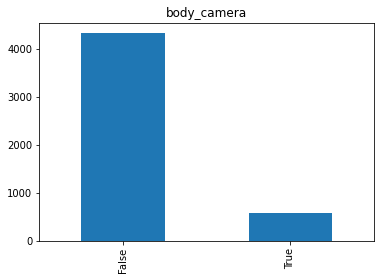

In [23]:
# plot_hist(complete, 'race')
# plot_hist(complete, 'arms_category')
# plot_hist(complete, 'threat_level')
# plot_hist(complete, target_feature)
plot_hist(complete, T)

In [24]:
ATE = {}

treated_outcome = np.mean(df[df[T] == 1][target_feature])
control_outcome = np.mean(df[df[T] == 0][target_feature])

naive_ATE = treated_outcome - control_outcome
ATE['naive'] = naive_ATE
print(naive_ATE)

0.013175560049470465


In [25]:
def evaluate(X, y, extra=""):
    # Testing the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dt = RandomForestClassifier(max_depth = 20, random_state=123)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    print(f'{extra} Train error: {np.mean((y_train-y_pred)**2)}')

    y_pred = dt.predict(X_test)
    print(f'{extra} Test error: {np.mean((y_test-y_pred)**2)}')

In [26]:
def get_data(df, T):
    curr_df = df.copy()
    T_ = curr_df[T]
    treated = curr_df[curr_df[T] == 1]
    control = curr_df[curr_df[T] == 0]
    X = curr_df.drop([T, target_feature], axis='columns')
    y = curr_df[target_feature]
    X_treated = treated.drop([T, target_feature], axis='columns')
    y_treated = treated[target_feature]
    X_control = control.drop([T, target_feature], axis='columns')
    y_control = control[target_feature]
    return X, y, X_treated, y_treated, X_control, y_control, T_

In [27]:
def clean(e, y, treatment):
    remove = np.where(e == treatment)
    e = np.delete(e, remove)
    y = y.to_numpy()
    y = np.delete(y, remove)
    return e, y


In [28]:
# IPW estimated ATE

X, y, X_treated, y_treated, X_control, y_control, T_ = get_data(df, T)
n = len(X)

rf = RandomForestClassifier(max_depth=20, random_state=123)
rf.fit(X, T_)

e_t = rf.predict_proba(X_treated)[:, 1]
e_c = rf.predict_proba(X_control)[:, 1]

e_t, y_treated = clean(e_t, y_treated, 0)
e_c, y_control = clean(e_c, y_control, 1)

first = np.sum(y_treated / e_t) / n
second = np.sum(y_control / (1 - e_c)) / n

IPW_ATE = round(first - second , 4)

print("ATE:", IPW_ATE)
ATE['ipw'] = IPW_ATE


ATE: 0.0011


In [29]:
# IPW comparison - Decision Tree classifier

from sklearn.tree import DecisionTreeClassifier

X, y, X_treated, y_treated, X_control, y_control, T_ = get_data(df, T)
n = len(X)

dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(X, T_)

e_t = dtc.predict_proba(X_treated)[:, 1]
e_c = dtc.predict_proba(X_control)[:, 1]

e_t, y_treated = clean(e_t, y_treated, 0)
e_c, y_control = clean(e_c, y_control, 1)

first = np.sum(y_treated / e_t) / n
second = np.sum(y_control / (1 - e_c)) / n

IPW_ATE = round(first - second , 4)

print("ATE:", IPW_ATE)
ATE['ipw -> dtc'] = IPW_ATE


ATE: 0.0012


In [30]:
# S-Learner estimated ATE

X = df.copy()

X = X.drop(target_feature, axis=1)
y = df[target_feature]

evaluate(X, y)

dt = RandomForestClassifier(max_depth = 20, random_state=123)  
dt.fit(X,y)

X_treated = X.copy()
X_treated[T] = 1
y_1 = dt.predict(X_treated)

X_control = X.copy()
X_control[T] = 0
y_0 = dt.predict(X_control)

s_learner_ATE = round(np.mean(y_1 - y_0), 4)

print(f'ATE: {s_learner_ATE}\n')

ATE['s-learner'] = s_learner_ATE

 Train error: 0.047242083758937695
 Test error: 0.06128702757916241
ATE: -0.0014



In [31]:
# S-Learner comparison - Decision Tree classifier

X = df.copy()

X = X.drop(target_feature, axis=1)
y = df[target_feature]

dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(X, y)

X_treated = X.copy()
X_treated[T] = 1
y_1 = dtc.predict(X_treated)

X_control = X.copy()
X_control[T] = 0
y_0 = dtc.predict(X_control)

s_learner_ATE = round(np.mean(y_1 - y_0), 4)

print(f'ATE: {s_learner_ATE}\n')

ATE['s-learner -> dtc'] = s_learner_ATE


ATE: -0.0004



In [32]:
# T-Learner estimated ATE


X = df.copy()
treated = df[df[T] == 1]

# creating treated-model, control-model
X_1 = treated.drop(target_feature, axis=1)
y = treated[target_feature]

evaluate(X_1, y, extra='X_1')
dt1 = RandomForestClassifier(max_depth = 20, random_state=123)  
dt1.fit(X_1, y)

control = df[df[T] == 0]
X_0 = control.drop(target_feature, axis=1)
y = control[target_feature]
evaluate(X_0, y, extra='X_0')
dt0 = RandomForestClassifier(max_depth = 20, random_state=123)
dt0.fit(X_0, y)

# Evaluating ATE
X = df.copy().drop(columns=[target_feature])
y = df[target_feature]
y_1 = dt1.predict(X)
y_0 = dt0.predict(X)

t_learner_ATE = round(np.mean(y_1 - y_0), 4)

print(f'ATE: {t_learner_ATE}\n')

ATE['t-learner'] = t_learner_ATE

X_1 Train error: 0.06277056277056277
X_1 Test error: 0.0603448275862069
X_0 Train error: 0.04923255140457573
X_0 Test error: 0.047453703703703706
ATE: -0.001



In [33]:
# T-Learner comparison - Decision Tree classifier

X = df.copy()
treated = df[df[T] == 1]

# creating treated-model, control-model
X_1 = treated.drop(target_feature, axis=1)
y = treated[target_feature]

dtc1 = DecisionTreeClassifier(random_state=123)
dtc1.fit(X_1, y)

control = df[df[T] == 0]
X_0 = control.drop(target_feature, axis=1)
y = control[target_feature]

dtc0 = DecisionTreeClassifier(random_state=123)
dtc0.fit(X_0, y)

# Evaluating ATE
X = df.copy().drop(columns=[target_feature])
y = df[target_feature]
y_1 = dtc1.predict(X)
y_0 = dtc0.predict(X)

t_learner_ATE = round(np.mean(y_1 - y_0), 4)

print(f'ATE: {t_learner_ATE}\n')

ATE['t-learner -> dtc'] = t_learner_ATE


ATE: -0.001



In [34]:
# Matching estimated ATE

X, y, X_treated, y_treated, X_control, y_control, T_ = get_data(df, T)

knn = KNeighborsClassifier(1, metric="hamming")
knn.fit(X_control, y_control)
pred = knn.predict(X_treated)

knn2 =  KNeighborsClassifier(1, metric="hamming")
knn2.fit(X_treated, y_treated)
pred2 = knn2.predict(X_control)

ITE1 = y_treated - pred
ITE2 = pred2 - y_control
ITE = ITE1.append(ITE2)

knn_ATE = round(np.mean(ITE), 4)


print("ATE:", knn_ATE)

ATE['matching'] = knn_ATE



ATE: 0.0239


In [35]:
# backdoor adjustment estimated ATE

ATE['backdoor_adj'] = []

# suspected confounders which we're trying to apply backdoor adjustment on
features_to_adjust = ['arms_category', 'race', 'threat_level']

# selecting only the relevant features - possible confounders, T, Y
X_sub = df.copy()[features_to_adjust + [T, target_feature]]

# getting all the types of entries per feature to go over all the combinations
values = []
for feature in features_to_adjust:
    available_values = list(X_sub[feature].unique())
    values.append(available_values)

# size of the entire dataset
size = len(X_sub)

probs = {}
# checking all possible combinations of suspected confounders
for combo in itertools.product(*values):
    # getting a subset which corresponds to the current combination
    combo_appearances = X_sub[(X_sub[features_to_adjust[0]] == combo[0]) &
                              (X_sub[features_to_adjust[1]] == combo[1]) &
                              (X_sub[features_to_adjust[2]] == combo[2])]
    probs[combo] = {}
    # probability of getting this combination of features
    probs[combo]['x'] = len(combo_appearances) / size

    # empty =  never occurs, irrelevant case
    if combo_appearances.empty:
        continue

    # subset of the treament records
    treated = combo_appearances[combo_appearances[T] == 1]
    # probability to get treatment under the given combination
    p_treated = len(treated) / len(combo_appearances)
    probs[combo]['T/x'] = [1 - p_treated, p_treated]
    
    probs[combo]['Y/T,x'] = {}
    # subset of the control records
    control = combo_appearances[combo_appearances[T] == 0]
    # subsets of treament records with outcome of 1
    y_treated = treated[treated[target_feature] == 1]
    # subsets of control records with outcome of 1
    y_control = control[control[target_feature] == 1]

    if not control.empty:
        # probablity to get positive outcome in the control subset
        p_y_control = len(y_control) / len(control)
        probs[combo]['Y/T,x'][0] = [1 - p_y_control, p_y_control]
    else:       # empty =  never occurs, irrelevant case
        probs[combo]['Y/T,x'][0] = [0, 0]

    if not treated.empty:
        # probablity to get positive outcome in the treament subset
        p_y_treated = len(y_treated) / len(treated)
        probs[combo]['Y/T,x'][1] = [1 - p_y_treated, p_y_treated]
    else:       # empty =  never occurs, irrelevant case
        probs[combo]['Y/T,x'][1] = [0, 0]

In [36]:
treated_out_sum = 0
control_out_sum = 0

for combo in probs.keys():
    if probs[combo]['x'] != 0:
        treated_out_sum += (1 * probs[combo]['Y/T,x'][1][1]) * probs[combo]['x']
        control_out_sum += (1 * probs[combo]['Y/T,x'][0][1]) * probs[combo]['x']

backdoor_adj_ATE = round(treated_out_sum - control_out_sum, 4)

print(f'ATE using backdoor adjustment: {backdoor_adj_ATE}\n')

ATE['backdoor_adj'] = backdoor_adj_ATE

ATE using backdoor adjustment: 0.0012



In [39]:
# print all ATE

print("Naive ATE: ", round(ATE['naive'], 4))
print()
print("*** Using random forest classifier: *** ")
print("IPW estimated ATE: ", ATE['ipw'])
print("S-Learner estimated ATE: ", ATE['s-learner'])
print("T-Learner estimated ATE: ", ATE['t-learner'])
print()
print("*** Using decision tree classifier: *** ")
print("IPW estimated ATE: ", ATE['ipw -> dtc'])
print("S-Learner estimated ATE: ", ATE['s-learner -> dtc'])
print("T-Learner estimated ATE: ", ATE['t-learner -> dtc'])
print()
print("Matching estimated ATE: ", ATE['matching'])
print("backdoor adjustment estimated ATE: ", ATE['backdoor_adj'])

Naive ATE:  0.0132

*** Using random forest classifier: *** 
IPW estimated ATE:  0.0011
S-Learner estimated ATE:  -0.0014
T-Learner estimated ATE:  -0.001

*** Using decision tree classifier: *** 
IPW estimated ATE:  0.0012
S-Learner estimated ATE:  -0.0004
T-Learner estimated ATE:  -0.001

Matching estimated ATE:  0.0239
backdoor adjustment estimated ATE:  0.0012
